In [1]:
# -- LOG -- #
import logging as log
log.basicConfig(filename='./Logs/activations.log',
                filemode='w',
                format='[%(asctime)s]:[%(name)s]:(%(levelname)s): %(message)s',
                level=log.INFO)

In [2]:
# -- IMPORTS -- #
try:
    from keras import models as kerasModels
    %matplotlib inline
    import matplotlib.pyplot as plt
    import keras.backend as K
    import json
    import h5py
    import random
    import numpy as np
    import pickle
    import os
    import subprocess
except Exception as e:
    log.error('Failed -- IMPORT:\n',exc_info=True)
    raise SystemExit(0)

Using TensorFlow backend.


In [3]:
# -- FIX MODEL -- #
def fix_layer0(filename, batchShape, dtype):
    with h5py.File(filename, 'r+') as f:
        model_config = json.loads(f.attrs['model_config'].decode('utf-8'))
        layer0 = model_config['config']['layers'][0]['config']
        layer0['batch_input_shape'] = batchShape
        layer0['dtype'] = dtype
        f.attrs['model_config'] = json.dumps(model_config).encode('utf-8')

In [4]:
# -- LOAD -- #
try:
    model = kerasModels.load_model('./Models/vgg16_mnist.h5')
except Exception as e:
    log.info('Fixing Input Layer:\n')
    fix_layer0('./Models/vgg16_mnist.h5',[None,32,32,3],'float32')
    model = kerasModels.load_model('./Models/vgg16_mnist.h5')
with open('./Data/Mnist_data.pkl','rb') as file:
    Xtest,Ytest = pickle.load(file)
model.summary()
log.info('LOAD: SUCCESS')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         295168    
__________

In [5]:
# -- VARIABLES FOR VISUALIZATION -- #
layerNames = []
layerOutputs = []
for layer in model.layers:
    if layer.__class__.__name__ == 'Conv2D':
        layerOutputs.append(layer.output)
        layerNames.append(layer.name)
visual = kerasModels.Model(inputs=model.input,outputs=layerOutputs)

In [6]:
# -- CHECK THE DIFFERENCES BETWEEN ACTIVATIONS GIVEN TWO IMAGES OF THE SAME CLASS -- #
numSelect = int(input('Select from (0-{0}):'.format(Ytest.shape[1]-1)))
samples = Xtest[Ytest[:,numSelect]>0]
start = random.randint(0,samples.shape[0])
samples = samples[start:start+11]
imageInput = []
RMSdiff = []
RMSmean = []
for k in range(samples.shape[0]):
    imageInput.append(np.reshape(samples[k],(1,32,32,3)))
act1 = visual.predict(imageInput[0]); act1 = act1[-1]
numFilters = act1.shape[-1]
cols = 32
rows = numFilters // cols
for k in range(1,len(imageInput)):
    act2 = visual.predict(imageInput[k]); act2 = act2[-1]
    for k in range(0,cols*rows):
        im1 = act1[0,:,:,k]
        im2 = act2[0,:,:,k]
        RMSdiff.append(np.sqrt(np.mean((im1-im2)**2)))
    RMSmean.append(np.sum(np.array(RMSdiff)))
    RMSdiff.clear()
print(len(RMSmean)*numFilters)
print(RMSmean)
RMSmean = np.mean(RMSmean)
print(RMSmean)

Select from (0-9): 4


5120
[28.622124, 17.20485, 27.693123, 22.923664, 24.860973, 28.585873, 30.293144, 22.15741, 27.074183, 16.286545]
24.570189


In [78]:
# -- CHECK THE DIFFERENCES BETWEEN ACTIVATIONS GIVEN TWO IMAGES OF DIFFERENT CLASS -- #
numSel1 = int(input('Select from (0-{0}):'.format(Ytest.shape[1]-1)))
numSel2 = int(input('Select from (0-{0}):'.format(Ytest.shape[1]-1)))
assert numSel1 != numSel2, 'Can not be the same number'
samples1 = Xtest[Ytest[:,numSel1]>0]
samples2 = Xtest[Ytest[:,numSel2]>0] 
start = random.randint(0,samples1.shape[0])
samples1 = samples1[start:start+10]
start = random.randint(0,samples2.shape[0])
samples2 = samples2[start:start+10]
imageInput1 = []; imageInput2 = []
RMSdiff = []
RMSmean = []
for k in range(samples.shape[0]):
    imageInput1.append(np.reshape(samples1[k],(1,32,32,3)))
    imageInput2.append(np.reshape(samples2[k],(1,32,32,3)))
cols = 32
for k in range(10):
    act1 = visual.predict(imageInput1[k]); act1 = act1[-1]
    act2 = visual.predict(imageInput2[k]); act2 = act2[-1]
    numFilters = act1.shape[-1]
    rows = numFilters // cols
    for k in range(0,cols*rows):
        im1 = act1[0,:,:,k]
        im2 = act2[0,:,:,k]
        RMSdiff.append(np.sqrt(np.mean((im1-im2)**2)))
    RMSmean.append(np.sum(np.array(RMSdiff)))
    RMSdiff.clear()
print(len(RMSmean)*numFilters)
print(RMSmean)
RMSmean = np.mean(RMSmean)
print(RMSmean)

Select from (0-9): 4
Select from (0-9): 9


5120
[44.54019, 42.630516, 23.47443, 39.213516, 44.710323, 35.802456, 32.26317, 35.22819, 51.506676, 47.345623]


Select from (0-9): 4
Select from (0-981):  452


/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(ne

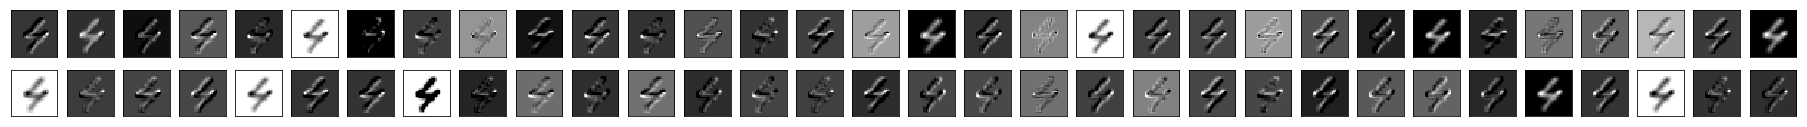

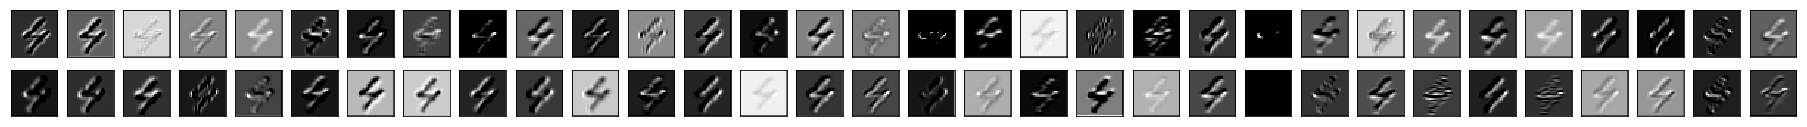

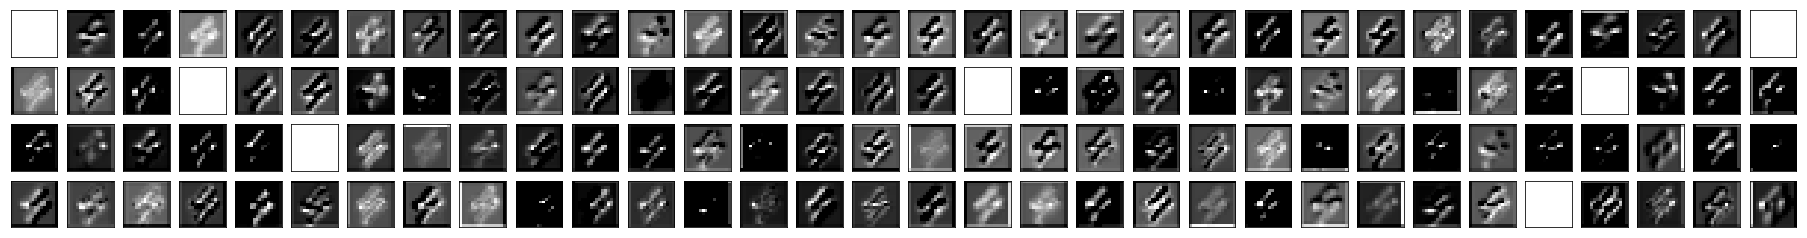

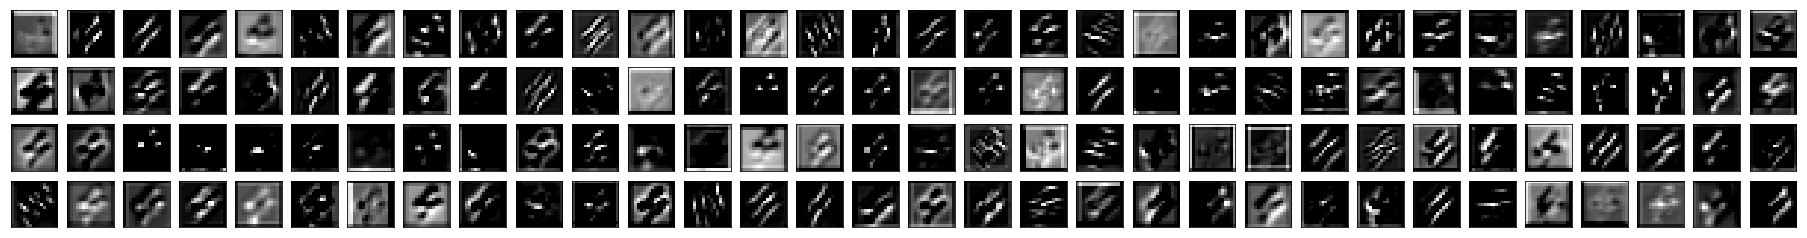

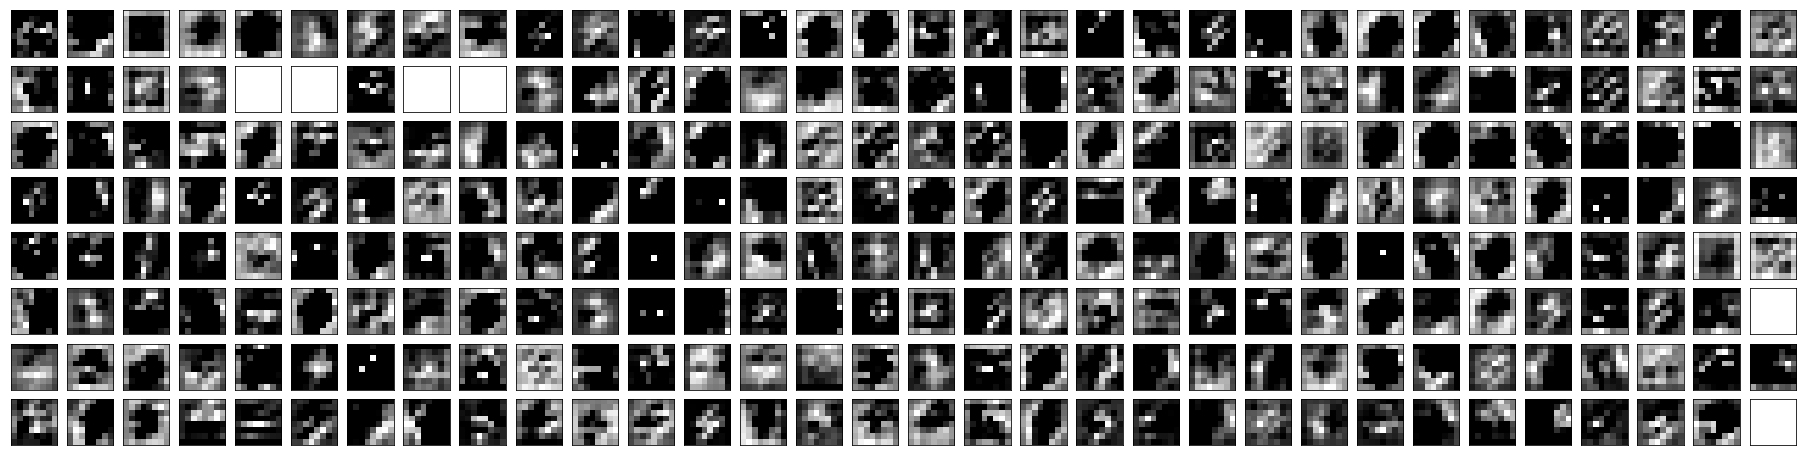

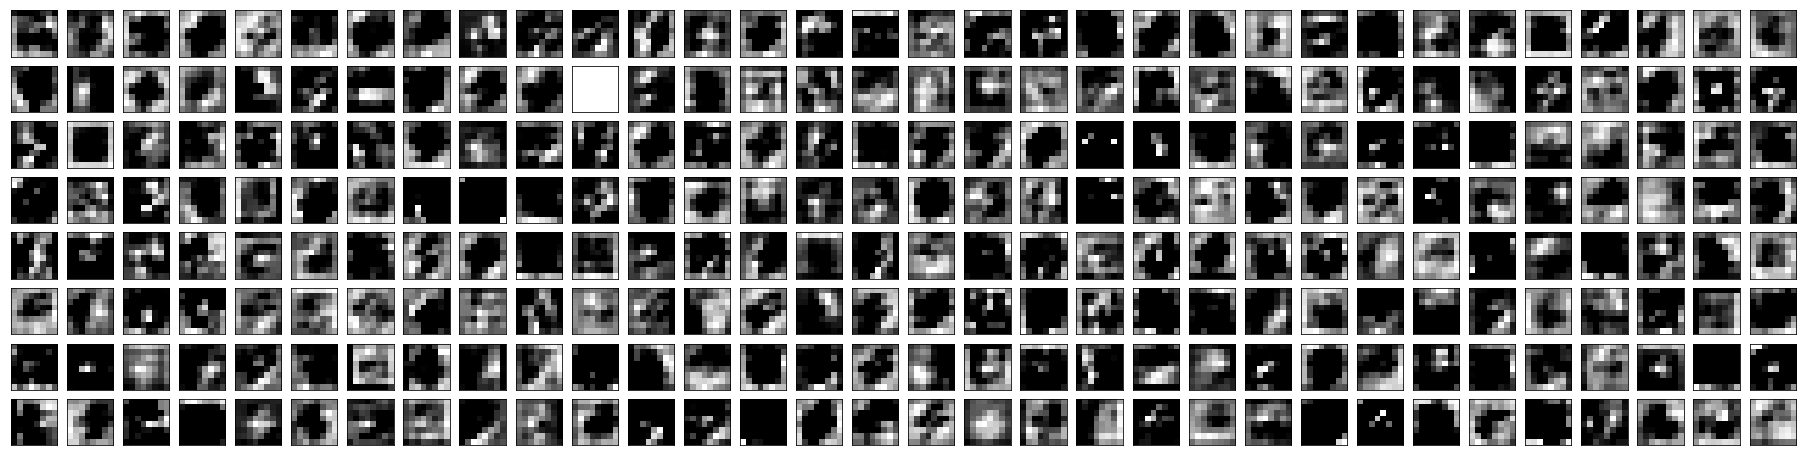

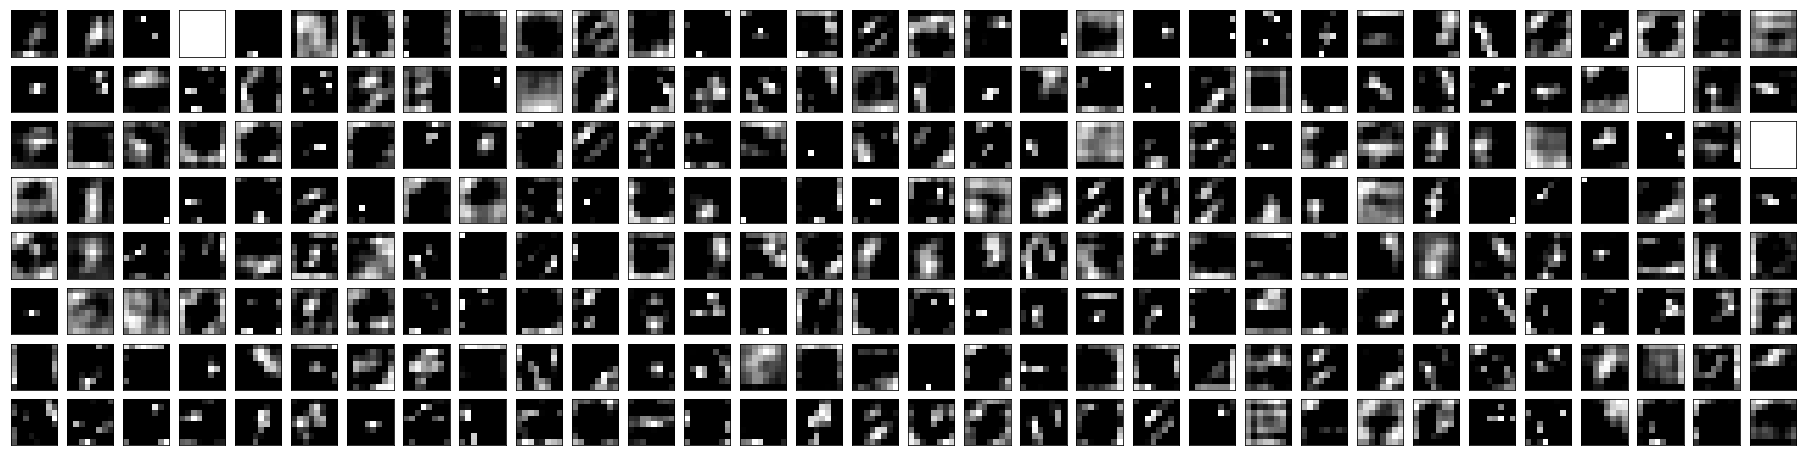

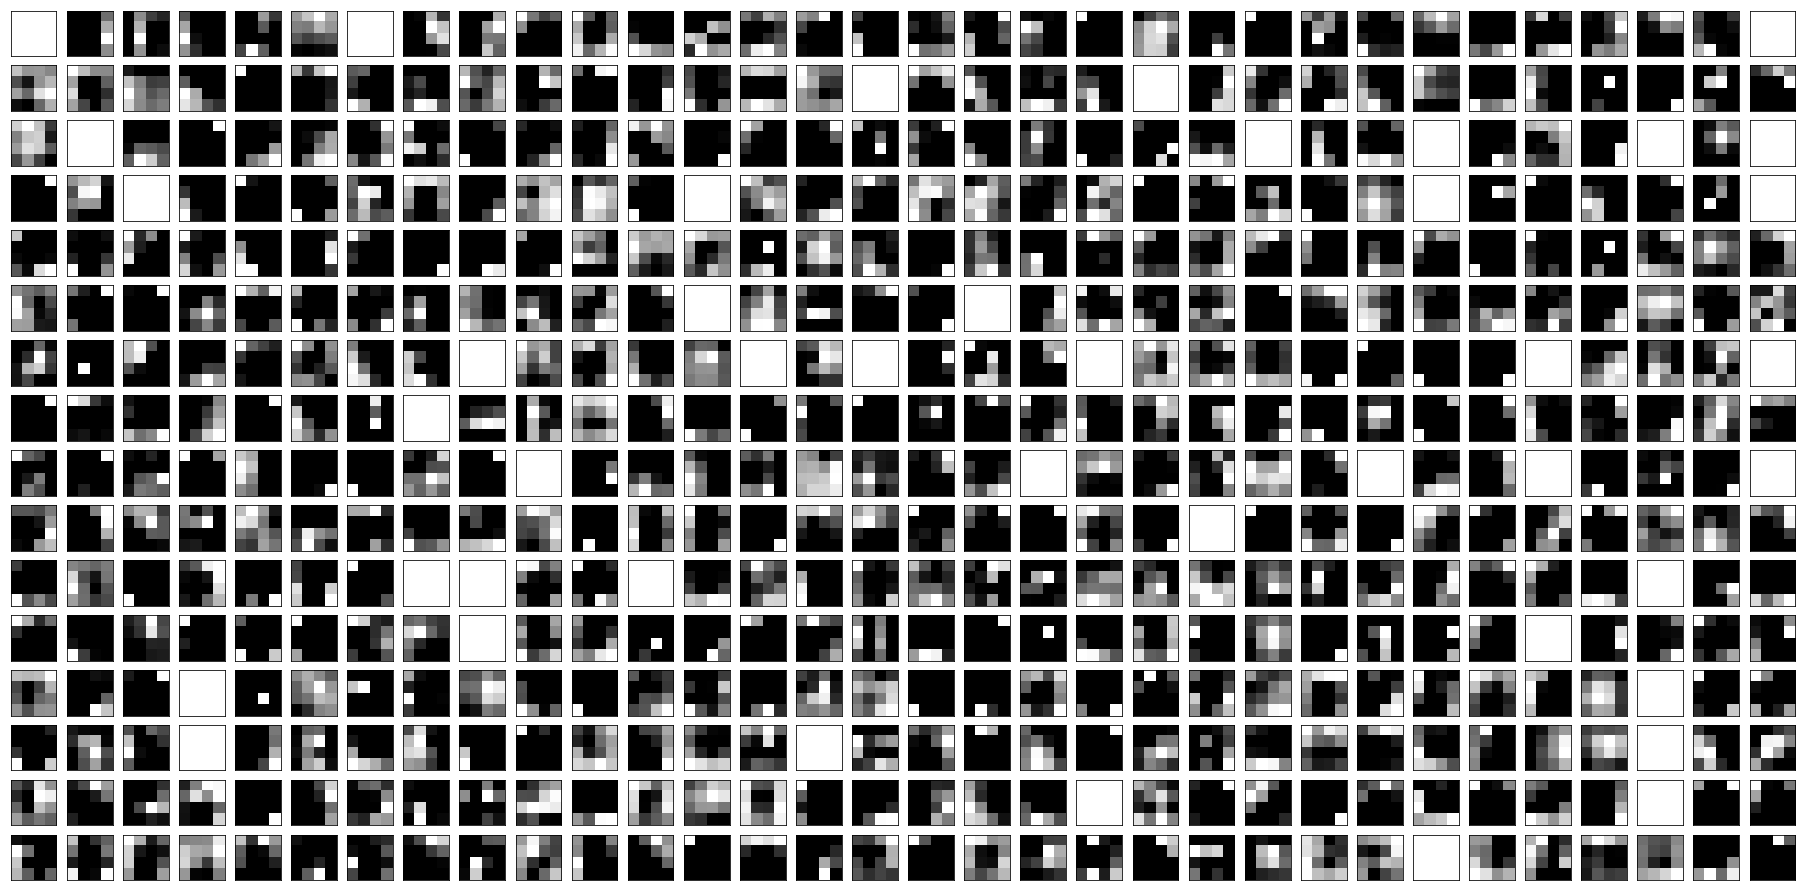

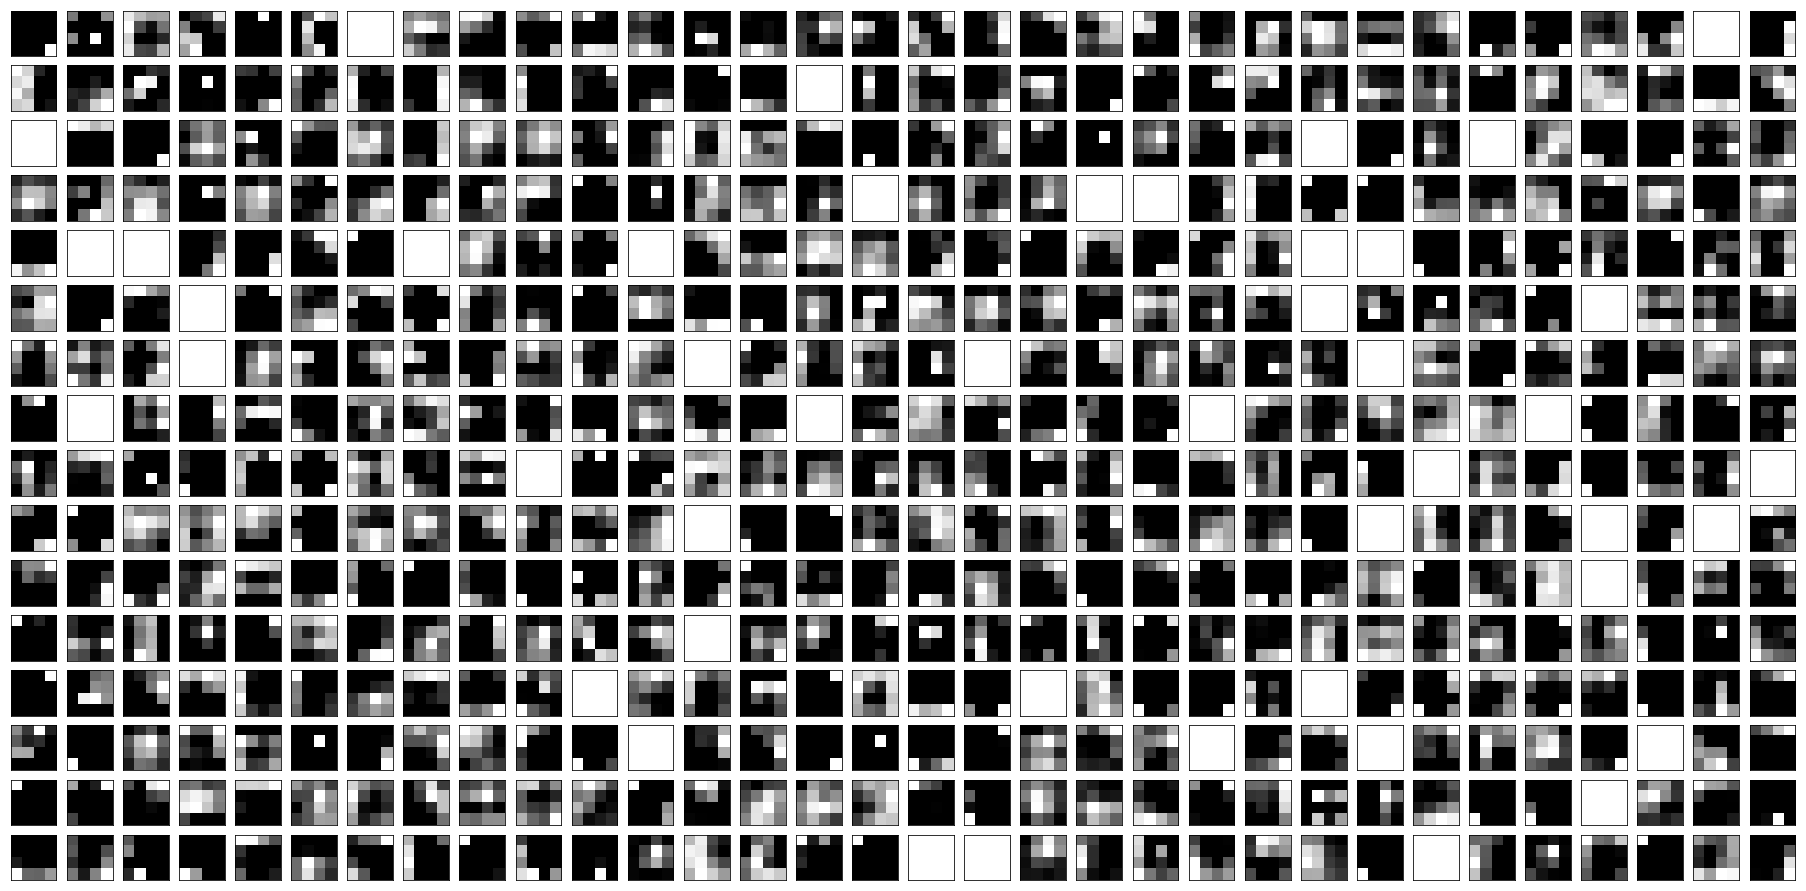

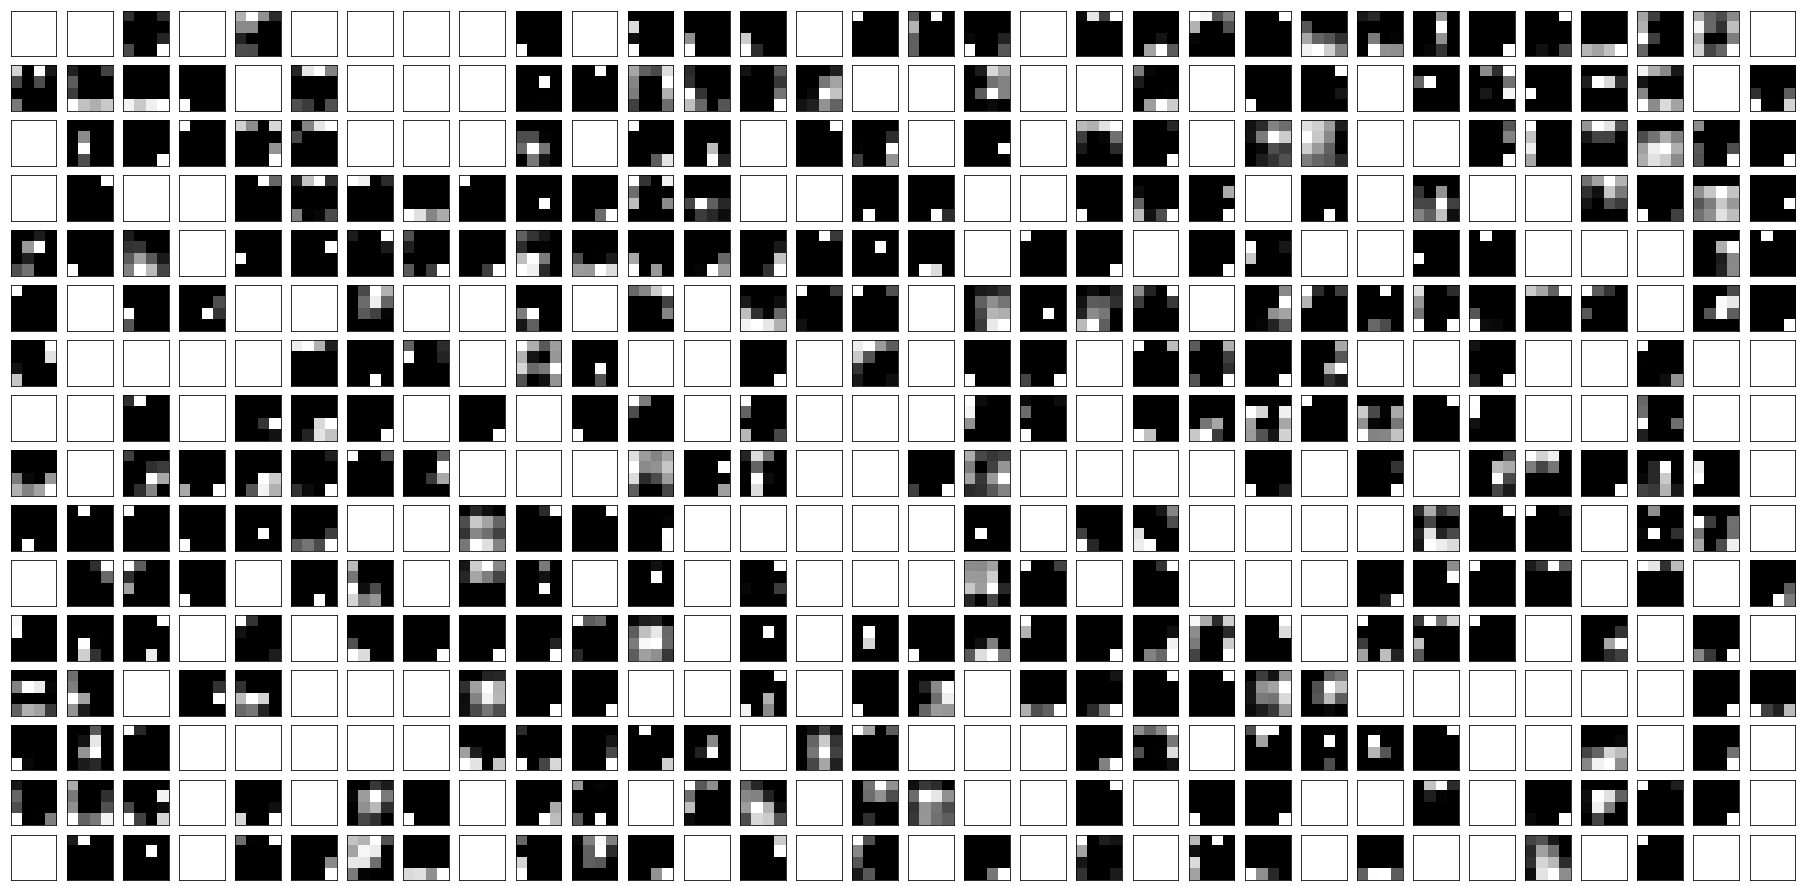

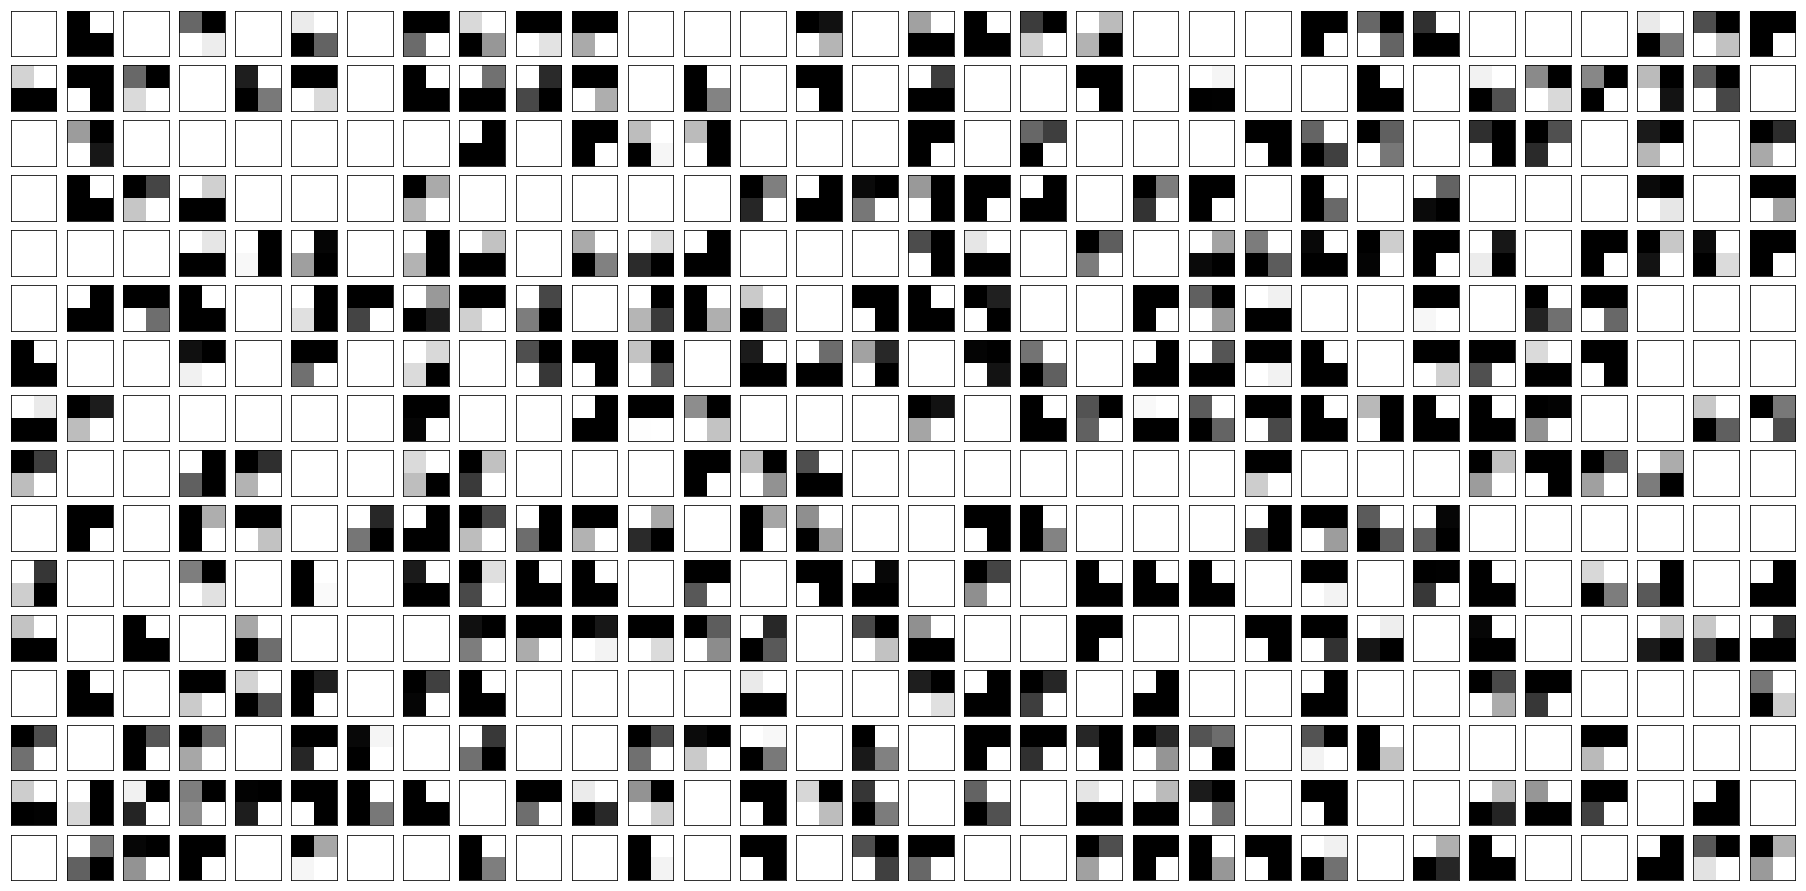

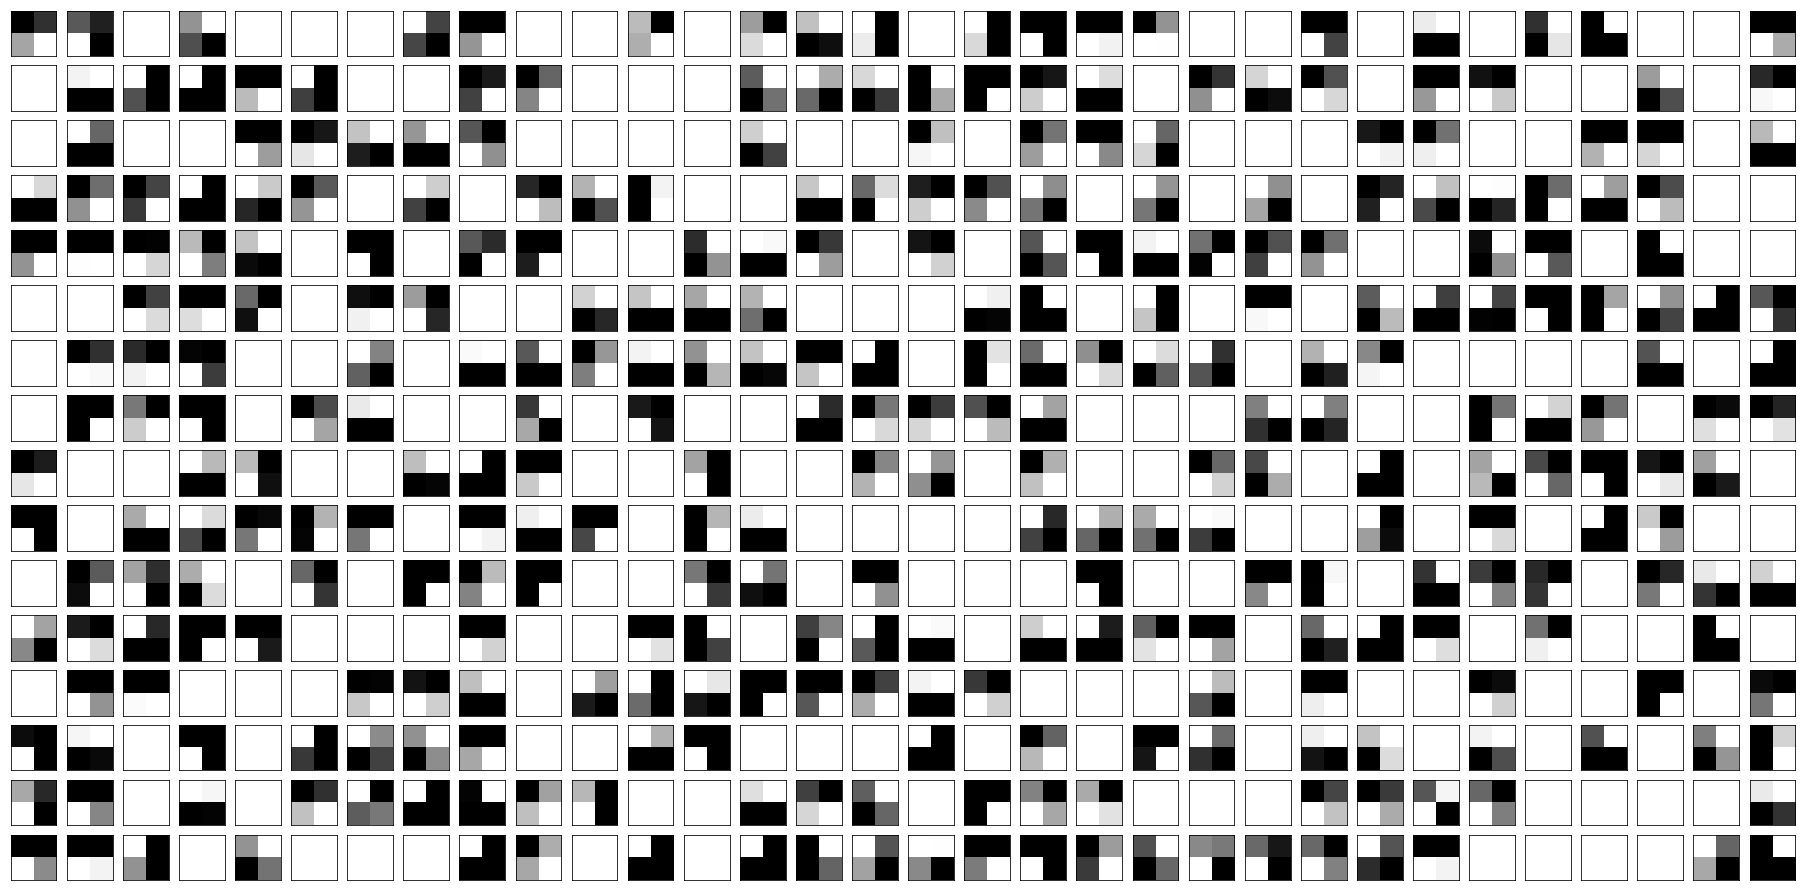

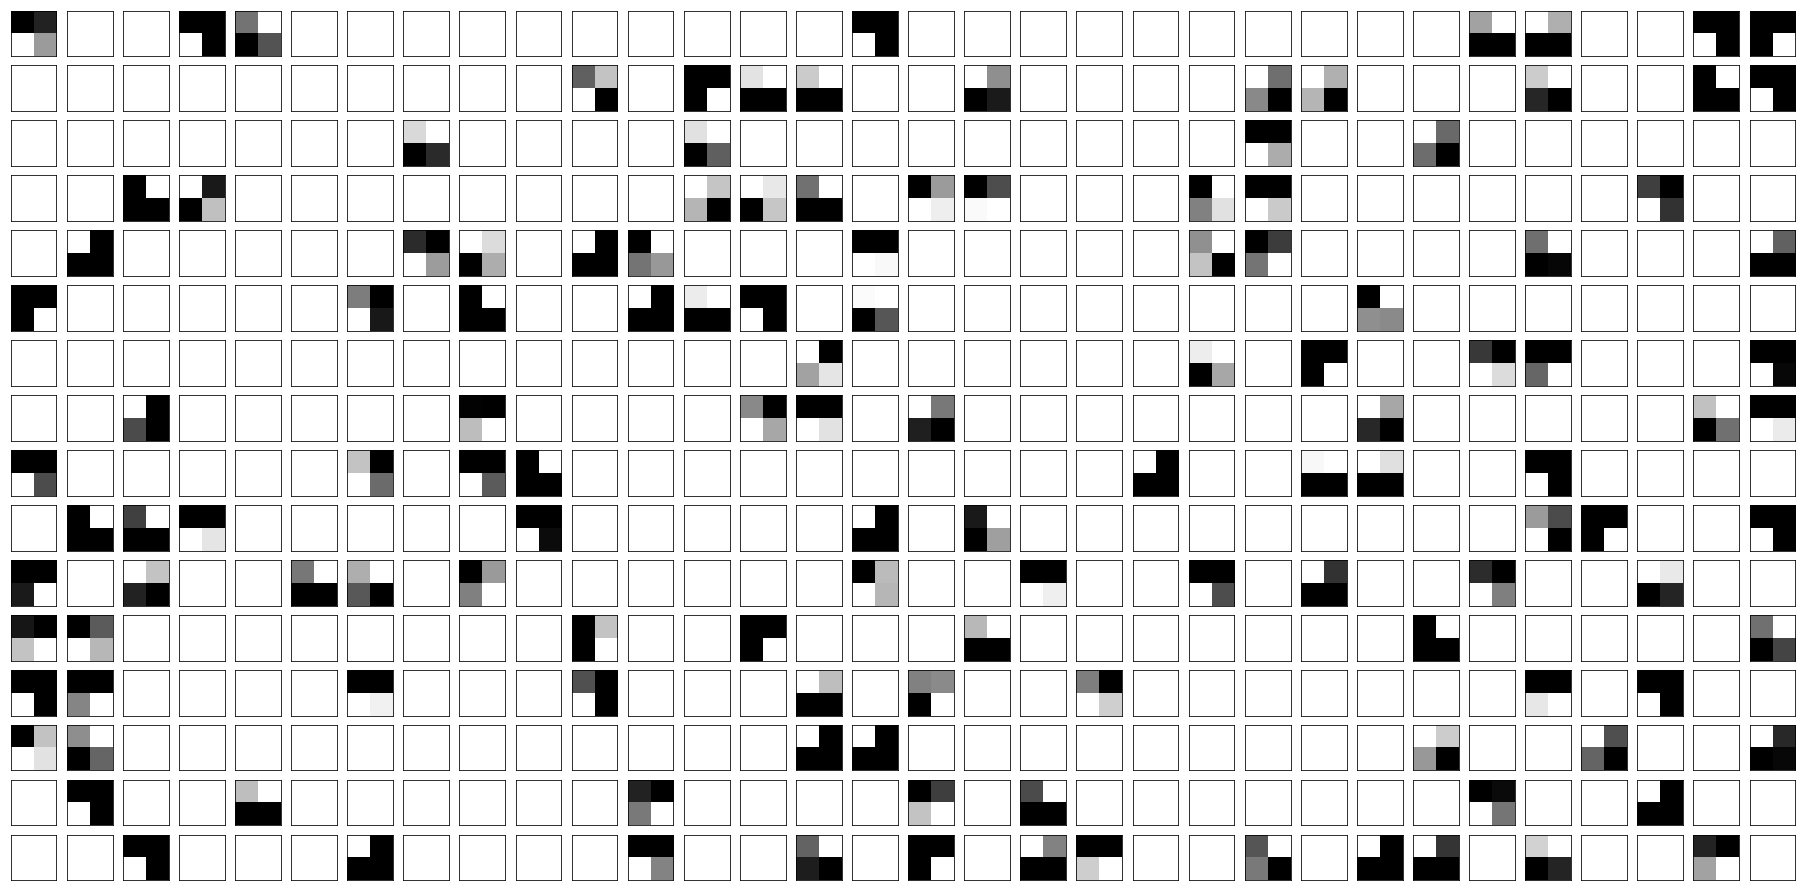

In [8]:
# -- VISUALIZATION OF ALL ACTIVATIONS GIVEN A IMAGE -- #
if not os.path.isdir('./Results/Activations'):
    os.mkdir('./Results/Activations')
else:
    subprocess.call('rm -rf ./Results/Activations',shell=True)
    os.mkdir('./Results/Activations')

# -- DEFINE VARIABLES -- # 
numSelect = int(input('Select from (0-{0}):'.format(Ytest.shape[1]-1)))
samples = Xtest[Ytest[:,numSelect]>0]
selected = random.randint(samples.shape[0]-1)
imageInput = np.reshape(samples[selected],(1,32,32,3))
activations = visual.predict(imageInput)
cols = 32

# -- SEE ACTIVATIONS -- #
for n,act in zip(range(len(activations)),activations):
    numFilters = act.shape[-1]; size = act.shape[1]
    rows = numFilters // cols
    fig = plt.figure(figsize=(cols,rows))
    for k in range(0,cols*rows):
        image = act[0,:,:,k]
        image = (image-np.min(image))/(np.max(image)-np.min(image)+K.epsilon())
        fig.add_subplot(rows,cols,k+1)
        plt.imshow(image,cmap=plt.cm.gray)
        plt.xticks([]); plt.yticks([])
    fileName = './Results/Activations/'+layerNames[n]+'.png'
    fig.savefig(fileName)       